In [1]:
import numpy as np

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel, sem

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    
    return onehot.cumsum(axis=time_axis)


def log_utility(counts):
    return np.log(counts[:, 1:] + 1).sum(axis=1)


def linear_utility(counts):
    return counts[:, 1:].sum(axis=1)


data = 'morgan'

# group_size = 1
# num_exps = 120
# num_repeats_per_exp = 5

group_size = 5
num_exps = 20
num_repeats_per_exp = 1

policies = [
    'ens jensen greedy',
    'classical ens',
    'greedy',
    'round robin greedy',
]
if group_size == 1 and 'round robin greedy' in policies:
    policies.remove('round robin greedy')
    
utility_function = log_utility

n_classes = group_size + 1
init_size = 1
budget = 500

basepath = os.path.join('../../data/results', data)
# basepath = os.path.join('../../data/results/backup/results 1101 - 1011', data)  # for sorted upperbound 5


utilities = np.ones(
    (len(policies), num_exps, num_repeats_per_exp, budget + init_size)
) * -1

for p_ind, policy in enumerate(policies):
    for exp_ind in range(num_exps):
        path = os.path.join(basepath, f'{data}{exp_ind + 1}', str(group_size), policy)
        for i in range(num_repeats_per_exp):
            labels = np.loadtxt(
                os.path.join(path, f'{policy}__labels__{i + 1}.csv'), 
                dtype=int
            ).flatten() - 1

            utilities[p_ind, exp_ind, i, :] = log_utility(labels_to_counts(labels))
        
assert np.all(utilities != -1)

In [3]:
utilities.shape

(4, 20, 1, 501)

In [4]:
utilities[..., -1].mean(axis=(1, 2))

array([12.19898859,  9.15083377, 10.87167379, 10.98620386])

ens jensen greedy: 12.1990
classical ens: 9.1508
greedy: 10.8717
round robin greedy: 10.9862


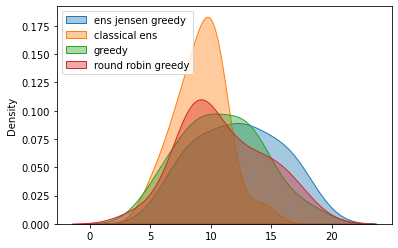

In [5]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, ..., -1].mean():.4f}')
    sns.kdeplot(utilities[p_ind, ..., -1].flatten(), alpha=0.4, shade=True, label=policy)
    
plt.legend(loc='upper left');

In [6]:
print(utilities.shape)
utilities

(4, 20, 1, 501)


array([[[[ 0.69314718,  0.69314718,  0.69314718, ..., 16.44295789,
          16.4594872 , 16.4760165 ]],

        [[ 0.69314718,  0.69314718,  0.69314718, ...,  8.41715184,
           8.44246965,  8.46716226]],

        [[ 0.69314718,  1.09861229,  1.09861229, ...,  7.90544165,
           7.94626364,  7.98548436]],

        ...,

        [[ 0.69314718,  0.69314718,  1.09861229, ...,  9.50718038,
           9.51576413,  9.52427482]],

        [[ 0.69314718,  0.69314718,  1.09861229, ...,  6.87626461,
           6.87626461,  6.87626461]],

        [[ 0.69314718,  0.69314718,  0.69314718, ..., 17.47287303,
          17.48629605, 17.49887483]]],


       [[[ 0.69314718,  0.69314718,  0.69314718, ...,  7.71110125,
           7.71110125,  7.71110125]],

        [[ 0.69314718,  1.09861229,  1.09861229, ...,  9.80200838,
           9.80200838,  9.80200838]],

        [[ 0.69314718,  1.09861229,  1.38629436, ..., 10.28301928,
          10.28301928, 10.30011371]],

        ...,

        [[ 0.693

In [7]:
squeezed_utilities =  utilities.reshape(
    len(policies), 
    num_exps * num_repeats_per_exp, 
    budget + init_size
)

print(squeezed_utilities.shape)
squeezed_utilities

(4, 20, 501)


array([[[ 0.69314718,  0.69314718,  0.69314718, ..., 16.44295789,
         16.4594872 , 16.4760165 ],
        [ 0.69314718,  0.69314718,  0.69314718, ...,  8.41715184,
          8.44246965,  8.46716226],
        [ 0.69314718,  1.09861229,  1.09861229, ...,  7.90544165,
          7.94626364,  7.98548436],
        ...,
        [ 0.69314718,  0.69314718,  1.09861229, ...,  9.50718038,
          9.51576413,  9.52427482],
        [ 0.69314718,  0.69314718,  1.09861229, ...,  6.87626461,
          6.87626461,  6.87626461],
        [ 0.69314718,  0.69314718,  0.69314718, ..., 17.47287303,
         17.48629605, 17.49887483]],

       [[ 0.69314718,  0.69314718,  0.69314718, ...,  7.71110125,
          7.71110125,  7.71110125],
        [ 0.69314718,  1.09861229,  1.09861229, ...,  9.80200838,
          9.80200838,  9.80200838],
        [ 0.69314718,  1.09861229,  1.38629436, ..., 10.28301928,
         10.28301928, 10.30011371],
        ...,
        [ 0.69314718,  0.69314718,  1.09861229, ...,  

In [8]:
for p1 in range(len(policies) - 1):
    for p2 in range(p1 + 1, len(policies)):
        if squeezed_utilities[p1, :, -1].mean() < squeezed_utilities[p2, :, -1].mean():
            alternative = "less"
        else:
            alternative = "greater"
        
        print(policies[p1], "vs.", policies[p2])
        print(
            ttest_rel(
                squeezed_utilities[p1, :, -1], 
                squeezed_utilities[p2, :, -1],
                alternative=alternative
            ).pvalue
        )
    print()

ens jensen greedy vs. classical ens
0.0011388934524031822
ens jensen greedy vs. greedy
0.07188889851072464
ens jensen greedy vs. round robin greedy
0.1674967580845969

classical ens vs. greedy
0.011405621663659582
classical ens vs. round robin greedy
0.029442914293613308

greedy vs. round robin greedy
0.4617183081225908



10.577285283604704 13.820691898500796
0.8109
8.162455477491124 10.139212066711613
0.4942
9.298409972328866 12.444937608874461
0.7866
9.36610477891449 12.606302938310218
0.8100


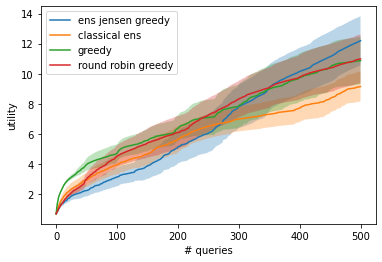

In [9]:
plt.figure()

for p_ind, policy in enumerate(policies):
    plt.plot(squeezed_utilities[p_ind].mean(axis=0), label=policy)
    lower, upper = DescrStatsW(squeezed_utilities[p_ind]).tconfint_mean()
    plt.fill_between(np.arange(init_size + budget), lower, upper, alpha=0.3)
    
    print(lower[-1], upper[-1])
    print(f'{(upper[-1] - lower[-1]) / 4:.4f}')
    
plt.xlabel("# queries")
plt.ylabel("utility")
plt.legend();